<a href="https://colab.research.google.com/github/cxbxmxcx/HandsOnGenerativeDeepLearning/blob/main/HOGDL_3_1_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot --quiet

In [ ]:
#@title The Imports
from tensorflow.keras.datasets import mnist as data
#from tensorflow.keras.datasets import fashion_mnist as data

#from tensorflow.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal

import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from tqdm import tqdm_notebook

import random
from tqdm.notebook import tqdm as tqdm

In [ ]:
#@title Load and Normalize Training/Test Data
(train_images, train_labels), (test_images, test_labels) = data.load_data()

# Scale Dataset -1 to +1
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 127.5 - 1

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
#@title Extract Class of Images
def extract(images, labels, class_):
  idx = labels == class_
  print(idx)
  imgs = images[idx]
  print(imgs.shape)
  return imgs

train_images = extract(train_images, train_labels, 5)

[ True False False ...  True False False]
(5421, 28, 28, 1)


In [ ]:
#@title Internal Hyperparameters and Optimizers Setup
latent_dim = 100

g_optimizer = Adam(0.0002, 0.5)
#d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5) 
d_optimizer = RMSprop(.001)

In [ ]:
#@title Determin
print(train_images.shape)
channels = train_images.shape[3]
img_shape = (train_images.shape[1], train_images.shape[2], channels)

(5421, 28, 28, 1)


In [ ]:
#@title Building the Generator (g)
def build_generator(latent_dim=100): 
  init = RandomNormal(stddev=0.02)
  in_lat = Input(shape=(latent_dim,)) 
  gen = Dense(256, kernel_initializer=init)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Dense(512, kernel_initializer=init)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Dense(1024, kernel_initializer=init)(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
  out_layer = Activation('tanh')(gen)
  out_layer = Reshape((28, 28, 1))(gen)
  model = Model(in_lat, out_layer)
  model.summary(0)
  return model

g = build_generator()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0     

In [ ]:
#@title Building the Discriminator (d)
def build_discriminator(in_shape=(28, 28, 1)):
  init = RandomNormal(stddev=0.02)  
  in_image = Input(shape=in_shape)
  fe = Flatten()(in_image)
  fe = Dense(1024)(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.3)(fe)
  fe = Dense(512)(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.3)(fe)
  fe = Dense(256)(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.3)(fe)
  out = Dense(1, activation='sigmoid')(fe)
  model = Model(in_image, out)  
  model.compile(loss='binary_crossentropy', optimizer=d_optimizer, metrics=['accuracy'])
  model.summary()
  return model

d = build_discriminator()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0   

In [ ]:
#@title Building the GAN
z = Input(shape=(latent_dim,))
img = g(z)

# For the combined model we will only train the generator
d.trainable = False

# The discriminator takes generated images as input and determines validity
valid = d(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
gan = Model(z, valid)
gan.compile(loss='binary_crossentropy', optimizer=g_optimizer)

In [ ]:
#@title Plot Helper Functions    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, latent_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, img_shape[0], img_shape[1])

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow((1-generated_images[i])*255, interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

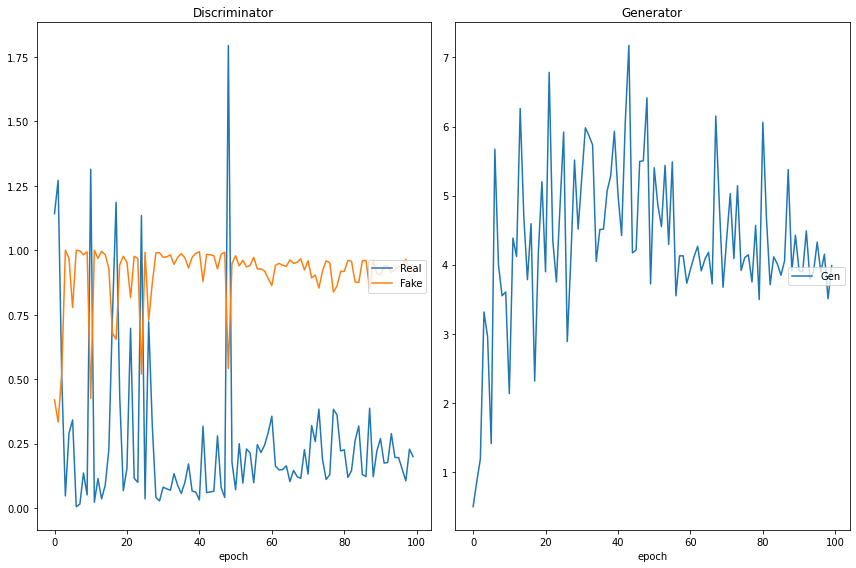

Discriminator
	Real             	 (min:    0.005, max:    1.794, cur:    0.200)
	Fake             	 (min:    0.334, max:    1.000, cur:    0.920)
Generator
	Gen              	 (min:    0.496, max:    7.173, cur:    3.986)


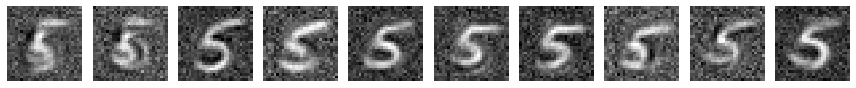

In [ ]:
#@title Training the GAN
EPOCHS = 100 #@param {type:"slider", min:5, max:100, step:1}
BATCH_SIZE = 256 #@param {type:"slider", min:64, max:256, step:2}

groups = { "Discriminator" : {"Real", "Fake"}, "Generator":{"Gen"}}
plotlosses = PlotLosses(groups=groups)

batches = int(train_images.shape[0] / BATCH_SIZE)

# Adversarial ground truths
valid = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

for e in range(EPOCHS):
  for i in tqdm(range(batches)):
    # ---------------------
    #  Train Discriminator
    # ---------------------
    # Select a random half of images
    idx = np.random.randint(0, train_images.shape[0], BATCH_SIZE)
    imgs = train_images[idx]  

    # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (BATCH_SIZE, latent_dim))
    gen_imgs = g.predict(noise)

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = d.train_on_batch(imgs, valid)
    d_loss_fake = d.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)  

    # ---------------------
    #  Train Generator
    # ---------------------
    # Train the generator (wants discriminator to mistake images as real)
    g_loss = gan.train_on_batch(noise, valid)  

  loss = dict(Real = d_loss[0], Fake = d_loss[1], Gen = g_loss)  
  plotlosses.update(loss)
  plotlosses.send()
  plot_generated()
